https://github.com/artix41/RIM-pytorch/blob/master/rim-toy.ipynb

https://github.com/wmorning/DeepClean

In [1]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [3]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [4]:
sys.path.append('../code/utils/')
sys.path.append('../code/flowpm/')
import tools
from background import *
import tfpm 
import tfpmfuncs as tfpf
from tfpmconfig import Config


# PM

In [5]:
#Generate DATA

pkfile = '../code/flowpm/Planck15_a1p00.txt'
stages = numpy.linspace(0.1, 1.0, 2, endpoint=True)
config = Config(bs=100, nc=32, seed=0, pkfile=pkfile, stages=stages)
bs, nc = config['boxsize'], config['nc']
sigma = 0.1**0.5
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
pkmesh = config['ipklin'](kmesh)
priorwt = config['ipklin'](kmesh) * bs ** -3


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


# Generate Data

In [6]:
#config = Config(bs=100, nc=32, seed=200, pkfile=pkfile)                                                                                                                                                                                                                                                                                                                   

def pmwhite(config, verbose=False):
    g = tf.Graph()
    with g.as_default():
        xx = tf.placeholder(tf.float32, (nc, nc, nc), name='white')
        whitec = tfpf.r2c3d(xx, norm=nc**3)
        lineark = tf.multiply(whitec, (pkmesh/bs**3)**0.5)
        linear = tfpf.c2r3d(lineark, norm=nc**3, name='linear')
        icstate = tfpm.lptinit(linear, config, name='icstate')
        fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
#         fnstate = icstate
        final = tf.zeros_like(linear)
        final = tfpf.cic_paint(final, fnstate[0], boxsize=config['boxsize'], name='final')
        tf.add_to_collection('pm', [linear, icstate, fnstate, final])
    return g




configs = []
ntrain, ntest = 500, 50

trains, traind, trainmapp = \
    np.zeros((ntrain, nc, nc, nc)), np.zeros((ntrain, nc, nc, nc)), np.zeros((ntrain, nc, nc, nc))
tests, testd, testmapp = \
    np.zeros((ntest, nc, nc, nc)), np.zeros((ntest, nc, nc, nc)), np.zeros((ntest, nc, nc, nc))

traininit, testinit = np.zeros((ntrain, nc, nc, nc)), np.zeros((ntest, nc, nc, nc)),

g = pmwhite(config)

with tf.Session(graph = g) as sess:

    sess.run(tf.global_variables_initializer())

    xx = g.get_tensor_by_name('white:0')
    linear = g.get_tensor_by_name('linear:0')
    final = g.get_tensor_by_name('final:0')
    for i in range(1, ntrain+1):
        if i%100 == 0: print(i)
        seed = i
        np.random.seed(seed)
        white = np.random.normal(loc=0, scale=nc**1.5, size=nc**3).reshape(nc, nc, nc)
        linmesh, finmesh, = sess.run([linear, final], feed_dict={xx:white})
        noise = np.random.normal(loc=0, scale=sigma, size=nc**3).reshape(nc, nc, nc).astype(config['dtype'])
        datan = finmesh + noise
        trains[i-1] = linmesh
        traind[i-1] = finmesh
        trainmapp[i-1] = datan
        traininit[i-1] = np.random.normal(0, 1, size=nc**3).reshape(nc, nc, nc).astype(config['dtype'])

    for i in range(1000, ntest+1000):
        if i%100 == 0: print(i)
        seed = i
        np.random.seed(seed)
        white = np.random.normal(loc=0, scale=nc**1.5, size=nc**3).reshape(nc, nc, nc)
        linmesh, finmesh, = sess.run([linear, final], feed_dict={xx:white})
        noise = np.random.normal(loc=0, scale=sigma, size=nc**3).reshape(nc, nc, nc).astype(config['dtype'])
        datan = finmesh + noise
        tests[i-1000] = linmesh
        testd[i-1000] = finmesh
        testmapp[i-1000] = datan
        testinit[i-1000] = np.random.normal(0, 1, size=nc**3).reshape(nc, nc, nc).astype(config['dtype'])


100
200
300
400
500
1000


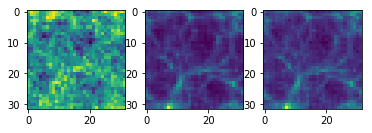

In [7]:
ii = np.random.choice(ntrain)

plt.subplot(131)
plt.imshow(trains[ii].sum(axis=0))
plt.subplot(132)
plt.imshow(traind[ii].sum(axis=0))
plt.subplot(133)
plt.imshow(trainmapp[ii].sum(axis=0))

# Brute force Gradient Descent to check it works

In [11]:
tf.reset_default_graph()


inchannnels = 1

def pm(lin):
    icstate = tfpm.lptinit(lin, config, name='icstate')
    fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(lin)
    final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
    return final


xx = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
xtrue = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
yy = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])


linear = tf.get_variable('linmesh', shape=(nc, nc, nc),
            initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
initlin_op = linear.assign(xx[0,..., 0], name='initlin_op')

final = pm(linear)

lineark = tfpf.r2c3d(linear, norm=nc**3)
priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
prior = tf.multiply(prior, 1/nc**3, name='prior')

likelihood = tf.subtract(final, tf.squeeze(yy))
residual = tf.multiply(likelihood, 1/sigma)

chisq = tf.multiply(residual, residual)
chisq = tf.reduce_sum(chisq)
chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

logposterior = tf.add(chisq, prior, name='logposterior')

# grads = tf.gradients(logposterior, [linear])[0]



opt = tf.train.AdamOptimizer(learning_rate=0.1)
grads = opt.compute_gradients(logposterior, [linear])
applygrads = opt.apply_gradients(grads)


In [12]:
start = time.time()
#Train

# with tf.Session() as sess:
sess = tf.Session()    
sess.run(tf.global_variables_initializer())

batchsize = 1

ind = [0]
ixx, ixtrue, iyy = traininit[ind], trains[ind], traind[ind]
ixx, ixtrue, iyy = np.expand_dims(ixx, -1), np.expand_dims(ixtrue, -1), np.expand_dims(iyy, -1)

for i in range(50):
    _ = sess.run(applygrads, {xx:ixx, xtrue:ixtrue, yy:iyy})

print(time.time()-start)

4.757709503173828


In [13]:
test = sess.run(linear, {xx:ixx, xtrue:ixtrue, yy:iyy})

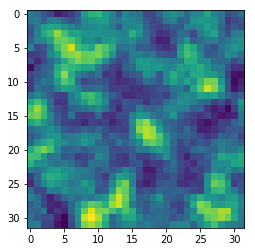

In [14]:
plt.imshow(test.sum(axis=0))

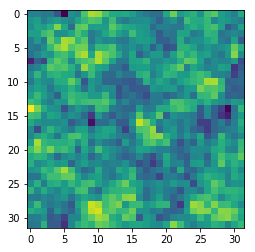

In [15]:
plt.imshow(trains[ind][0].sum(axis=0))

# RIM

In [16]:
# https://github.com/kaustubhhiware/LSTM-GRU-from-scratch/blob/80eb6bca2192e40dd718c6c7bd8830119d78a620/module.py
    
class GRU_cell3D(object):


    def __init__(self, name, input_channels, hidden_units, output_channels, kernel=3, strides=1):

        self.kernel = kernel
        self.strides = [strides, strides, strides, strides, strides]
        self.input_channels = input_channels
        self.hidden_units = hidden_units
        self.output_channels = output_channels
        self.name = name
        
        k_h, k_w, k_z = [kernel]*3
        fan_in = k_h * k_w * k_z * input_channels
        stddev = tf.sqrt(2. / (fan_in))
        n_out = output_channels
        print(stddev)
        self.initializer = tf.truncated_normal_initializer(stddev=stddev)
#         self.initializer = tf.ones_initializer()
        self.zeroinitializer = tf.zeros_initializer()
#         self.zeroinitializer = tf.truncated_normal_initializer(stddev=stddev)
        #
        #
        self.Wx = tf.get_variable(name=name+'/Wx', 
                shape = [self.kernel, self.kernel, self.kernel, self.input_channels, self.hidden_units], 
                initializer =self.zeroinitializer, trainable=True) #maybe 0 init is better?
        self.Wr = tf.get_variable(name=name+'/Wr', 
                shape = [self.kernel, self.kernel, self.kernel, self.input_channels, self.hidden_units], 
                initializer =self.zeroinitializer, trainable=True) #maybe 0 init is better?
        self.Wz = tf.get_variable(name=name+'/Wz', 
                shape = [self.kernel, self.kernel, self.kernel, self.input_channels, self.hidden_units], 
                initializer =self.zeroinitializer, trainable=True) #maybe 0 init is better?
        self.Wh = tf.get_variable(name=name+'/Wh', 
                shape = [self.kernel, self.kernel, self.kernel, self.hidden_units, self.hidden_units], 
                initializer =self.zeroinitializer, trainable=True) #maybe 0 init is better?
        self.Wo = tf.get_variable(name=name+'/Wo', 
                shape = [self.kernel, self.kernel, self.kernel, self.hidden_units, self.output_channels], 
                initializer =self.initializer, trainable=True) 
        
        self.br = tf.get_variable(name=name+'/br', shape = [self.hidden_units], 
                initializer =self.initializer, trainable=True)
        self.bz = tf.get_variable(name=name+'/bz', shape = [self.hidden_units], 
                initializer =self.initializer, trainable=True)
        self.bo = tf.get_variable(name=name+'/bo', shape = [self.output_channels], 
                initializer =self.initializer, trainable=True)

        
        self.initial_hidden = tf.placeholder(name='initialhidden', dtype=tf.float32,
                shape=[None, None, None, None, self.hidden_units])

        
    def Gru(self, previous_hidden_state, x):

        z = tf.sigmoid(tf.nn.conv3d(x, self.Wz, strides=self.strides, padding='SAME') + self.bz)
        r = tf.sigmoid(tf.nn.conv3d(x, self.Wr, strides=self.strides, padding='SAME') + self.br)

        h_ = tf.tanh(tf.nn.conv3d(x, self.Wx, strides=self.strides, padding='SAME') +
            tf.nn.conv3d(previous_hidden_state, self.Wh, strides=self.strides,padding='SAME')*r)

        current_hidden_state = tf.multiply( (1 - z), h_) + tf.multiply(previous_hidden_state, z)

        return current_hidden_state

    def get_output(self, hidden_state):
#         output = tf.nn.leaky_relu(tf.nn.conv3d(hidden_state, self.Wo, 
#                                 strides=self.strides, padding='SAME') + self.bo)
        output = (tf.nn.conv3d(hidden_state, self.Wo, 
                                strides=self.strides, padding='SAME') + self.bo)
        return output



In [ ]:
tf.reset_default_graph()


def pm(lin):
    icstate = tfpm.lptinit(lin, config, name='icstate')
    fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(lin)
    final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
    return final

inchannnels, outchannels = 1, 8
hidden_units = 32


xx = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
xtrue = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
yy = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
lr = tf.placeholder(tf.float32)

opt = tf.train.GradientDescentOptimizer(learning_rate=lr)

mygru3d = GRU_cell3D('mygru', inchannnels*2, hidden_units, outchannels)
hidden = mygru3d.initial_hidden

losst = tf.get_variable('loss', initializer=0., trainable=False)
reset_loss = losst.assign(0)


hiter, xiter = [], []
xlin = xx
losslist = []
xiter.append(xlin)
hiter.append(hidden)
giter = []
niter = []

W0 = tf.get_variable('W0', shape = [3, 3, 3, 2, 2], trainable=True) 
W1 = tf.get_variable('W1', shape = [3, 3, 3, outchannels, 1], trainable=True) 
# W2 = tf.get_variable('W2', shape = [3, 3, 3, outchannels, 1], trainable=True) 

for i in range(10):

    linear = tf.stop_gradient(xlin[0,...,0])
    final = pm(linear)
    
    likelihood = tf.subtract(final, tf.squeeze(yy))
    residual = tf.multiply(likelihood, 1/sigma)

    chisq = tf.multiply(residual, residual)
    chisq = tf.reduce_sum(chisq)
    chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

    lineark = tfpf.r2c3d(linear, norm=nc**3)
    priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
    prior = tf.multiply(prior, 1/nc**3, name='prior')

    logposterior = tf.add(chisq, prior, name='logposterior')
#     grads = tf.gradients(logposterior, [xlin])[0]
    grads = tf.gradients(logposterior, [linear])[0]*10

    giter.append(grads)
    xcat = tf.concat([xlin, tf.expand_dims(tf.expand_dims(grads, 0), -1)], axis=-1)
#     xcat = tf.concat([xlin, grads], axis=-1)
    net = tf.nn.conv3d(xcat, W0, strides=(1, 1, 1, 1, 1), padding='SAME')
    
    hidden = mygru3d.Gru(hidden, net)
    hiter.append(hidden)

    net = mygru3d.get_output(hidden)
    net = tf.nn.tanh(tf.nn.conv3d(net, W1, strides=(1, 1, 1, 1, 1), padding='SAME'))
#     net = (tf.nn.conv3d(net, W1, strides=(1, 1, 1, 1, 1), padding='SAME'))
    niter.append(net)

    xout = xlin + net
    iloss = tf.reduce_mean((xout - xtrue)**2)
    losslist.append(iloss)
    losst = losst + iloss
    xlin = xout
    xiter.append(xlin)

opt_op = opt.minimize(losst)


Tensor("Sqrt:0", shape=(), dtype=float32)


In [ ]:
start = time.time()
#Train


sess = tf.Session()    
sess.run(tf.global_variables_initializer())
llist = []

batchsize = 1

zerohidden = np.zeros((batchsize, nc, nc, nc, hidden_units)).astype(float32)

for nb in range(20):

    ind = np.random.choice(trains.shape[0], batchsize)
#     ind = [0]
    sess.run(reset_loss)
    ixx, ixtrue, iyy = traininit[ind], trains[ind], traind[ind]
    ixx, ixtrue, iyy = np.expand_dims(ixx, -1), np.expand_dims(ixtrue, -1), np.expand_dims(iyy, -1)

    _, l, ll, ix, inn, ih, ig = sess.run([opt_op, losst, losslist, xiter, niter, hiter, giter], 
                                      {xx:ixx, xtrue:ixtrue, yy:iyy, mygru3d.initial_hidden:zerohidden, 
                                      lr:0.05})

    if nb %50 == 0: 
        print('Step : ', nb, ' Loss : ', l)
#     print(l)
    llist.append(l)

print(time.time()-start)

In [ ]:
plt.plot(llist)
plt.loglog()

In [ ]:
plt.imshow(np.squeeze(ix[0]).sum(axis=0))
plt.colorbar()
plt.show()
plt.imshow(np.squeeze(ixtrue).sum(axis=0))
plt.colorbar()
plt.show()


In [ ]:
xsize = len(ix)
plt.figure(figsize = (4, xsize*4))
for i in range(xsize):
    plt.subplot( xsize,1, i+1)
    plt.imshow(np.squeeze(ix[i]).sum(axis=0))
    plt.colorbar()    

In [ ]:
ix[0]/ixtrue[0]

In [ ]:
ix[0]/ix[-1]

In [ ]:
plt.hist((ix[0]/ix[-1]).flatten())

# Toy example

# Create the simulator and the data

The simulator is defined as $y=Ax + n$ where $A$ is a deterministic matrix and $n \sim \mathcal{N}(0,\sigma^2)$ with $\sigma$ known. The loss will then be defined to be $\mathcal{L}(x,y)=\frac{1}{2} x^T A^T A x - y^T A x$.


In [55]:
nb_samples = 100
batch_size = 16
time_max_rim = 30
time_max_gd = 60
nb_epochs = 2

size_train = 1000
size_test = 500



In [56]:
def simulate(x, A, sigma):
    return np.dot(A,x) + np.random.normal(0,sigma, (2,))

def generate_A():
    D = np.diag(np.random.choice([-1,1], (2,)) * np.random.uniform(0.25, 1, (2,)))
    theta = np.random.uniform(0,2*np.pi)
    P = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return np.linalg.inv(P).dot(D).dot(P)
    

In [57]:
A_train = np.array([generate_A() for i in range(size_train)])
sigma_train = np.array([np.abs(np.random.uniform(0, 1)) for i in range(size_train)])

X_train = np.array([np.random.uniform(-5, 5, (2,)) for i in range(size_train)])
Y_train = np.array([simulate(x, A, sigma) for (x, A, sigma) in zip(X_train, A_train, sigma_train)])
X_min_train = np.array([np.linalg.inv(A).dot(y) for (A,y) in zip(A_train,Y_train)])
X0_train = np.array([x_min + np.random.uniform(-10,10,(2,)) for x_min in X_min_train])

#
A_test = np.array([generate_A() for i in range(size_test)])
sigma_test = np.array([np.abs(np.random.uniform(0, 1)) for i in range(size_test)])

X_test = np.array([np.random.uniform(-5, 5, (2,)) for i in range(size_test)])
Y_test = np.array([simulate(x, A, sigma) for (x, A, sigma) in zip(X_test, A_test, sigma_test)])
X_min_test = np.array([np.linalg.inv(A).dot(y) for (A,y) in zip(A_test,Y_test)])
X0_test = np.array([x_min + np.random.uniform(-10,10,(2,)) for x_min in X_min_test])


In [58]:
def loss(x, y, A):
    return 0.5 * x.T.dot(A.T).dot(A).dot(x) -  y.T.dot(A).dot(x)

def gradient(x, y, A):
    return A.T.dot(A.dot(x) - y)



In [59]:
extent_x, extent_y = 14, 6
xx_grid = np.array([np.linspace(x_min[0]-extent_x, x_min[0]+extent_x, 50) for x_min in X_min_test])
yy_grid = np.array([np.linspace(x_min[1]-extent_y, x_min[1]+extent_y, 50) for x_min in X_min_test])


XY_grid = np.array([np.meshgrid(xx, yy) for (xx,yy) in zip(xx_grid, yy_grid)])
X_grid = XY_grid[:,0,:,:]
Y_grid = XY_grid[:,1,:,:]
grid = np.concatenate([X_grid[:,:,:,np.newaxis], Y_grid[:,:,:,np.newaxis]], axis=3)

Z_grid = np.array([np.apply_along_axis(lambda x: loss(x, y, A), 2, g) for (y,A,g) in zip(Y_test, A_test, grid)])




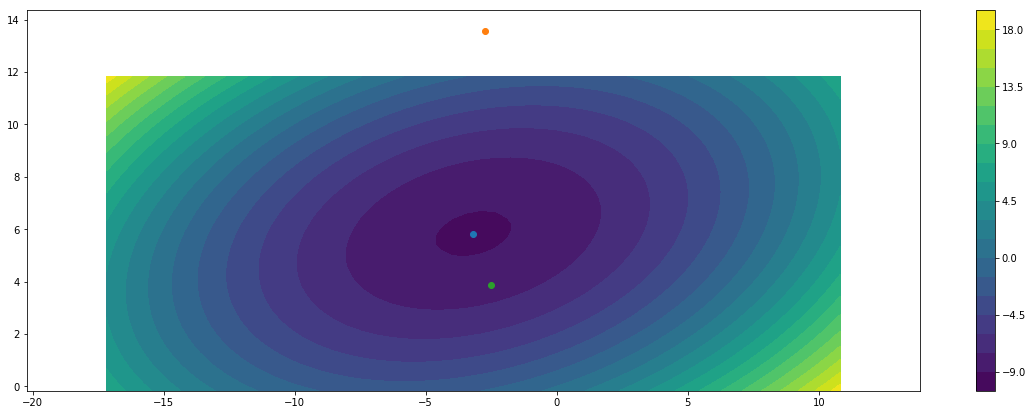

In [60]:

i_example = 37

plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar()
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1])
plt.scatter(X_test[i_example][0], X_test[i_example][1], color=colormap[2])
plt.scatter(X0_test[i_example][0], X0_test[i_example][1])




# Gradient Descent

In [61]:
lr = 0.1
list_xt_gd = []

for (x0, y, A) in zip(X0_test, Y_test, A_test):
# for (x0, y, A) in zip(X0_train, Y_train, A_train):
    xt = x0.copy()
    list_xt = [x0]
    for t in range(1, time_max_gd):
        xt = xt - lr * gradient(xt, y, A)
        list_xt.append(xt)
    list_xt_gd.append(list_xt)
list_xt_gd = np.array(list_xt_gd)

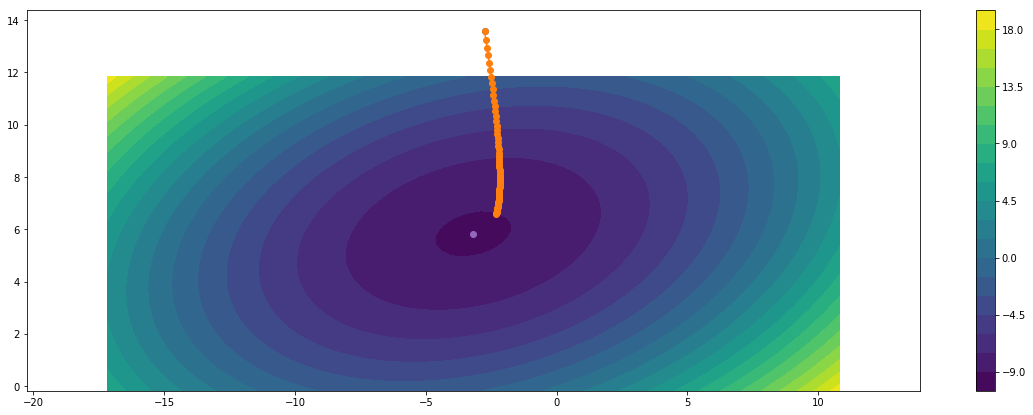

In [62]:
i_example = 37

plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar()
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1], c=colormap[4])
plt.scatter(X0_test[i_example][0], X0_test[i_example][1])
# plt.scatter(X_min_train[i_example][0], X_min_train[i_example][1], c=colormap[4])
# plt.scatter(X0_train[i_example][0], X0_train[i_example][1])

plt.plot(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], color=colormap[1])
plt.scatter(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], c=colormap[1])

# RIM

In [63]:
# https://github.com/kaustubhhiware/LSTM-GRU-from-scratch/blob/80eb6bca2192e40dd718c6c7bd8830119d78a620/module.py
    
class GRU_cell(object):

    def __init__(self, name, input_nodes, hidden_unit, output_nodes):

        self.input_nodes = input_nodes
        self.hidden_unit = hidden_unit
        self.output_nodes = output_nodes
        self.name = name
        
        self.Wx = tf.Variable(tf.zeros([self.input_nodes, self.hidden_unit]), name=name+'/Wx')

        self.Wr = tf.Variable(tf.zeros([self.input_nodes, self.hidden_unit]), name=name+'/Wr')
        self.br = tf.Variable(tf.truncated_normal([self.hidden_unit], mean=1), name=name+'/br')
        
        self.Wz = tf.Variable(tf.zeros([self.input_nodes, self.hidden_unit]), name=name+'/Wz')
        self.bz = tf.Variable(tf.truncated_normal([self.hidden_unit], mean=1), name=name+'/bx')

        self.Wh = tf.Variable(tf.zeros([self.hidden_unit, self.hidden_unit]), name=name+'/Wh')

        self.Wo = tf.Variable(tf.truncated_normal([self.hidden_unit, self.output_nodes], 
                                                  mean=1, stddev=.01), name=name+'/Wo')
        self.bo = tf.Variable(tf.truncated_normal([self.output_nodes], 
                                                  mean=1, stddev=.01), name=name+'/b0')

        self._inputs = tf.placeholder(tf.float32, shape=[None, self.input_nodes])
        self.initial_hidden = tf.zeros_like(self._inputs)
        self.initial_hidden = tf.matmul(self.initial_hidden, tf.zeros([input_nodes, hidden_unit]))

        
    def Gru(self, previous_hidden_state, x):

        z = tf.sigmoid(tf.matmul(x, self.Wz) + self.bz)
        r = tf.sigmoid(tf.matmul(x, self.Wr) + self.br)

        h_ = tf.tanh(tf.matmul(x, self.Wx) +
                     tf.matmul(previous_hidden_state, self.Wh) * r)

        current_hidden_state = tf.multiply( (1 - z), h_) + tf.multiply(previous_hidden_state, z)

        return current_hidden_state

    def get_output(self, hidden_state):
#         output = tf.nn.relu(tf.matmul(hidden_state, self.Wo) + self.bo)
        output = tf.nn.leaky_relu(tf.matmul(hidden_state, self.Wo) + self.bo)
        return output



In [64]:
# tf.reset_default_graph()


# output_size = 2
# hidden_size = 10
# tsteps = 1
# batch_size = None


# xtrue = tf.placeholder(shape=[batch_size, output_size], dtype=tf.float32)
# xinp = tf.placeholder(shape=[batch_size, output_size], dtype=tf.float32)
# AA = tf.placeholder(shape=[batch_size, output_size, output_size], dtype=tf.float32)
# yy = tf.placeholder(shape=[batch_size,  output_size], dtype=tf.float32)

# #
# xx = xinp

# # fidloss =  0.5 * tf.einsum(x.T.dot(A.T).dot(A).dot(x) -  y.T.dot(A).dot(x)
# fidloss =  0.5 * tf.einsum('bi,bi->b', xx, tf.einsum('bij,bi->bj', AA, tf.einsum('bij,bj->bi', AA, xx)                                                       ))
# fidloss = fidloss -  tf.einsum('bi,bi->b', yy, tf.einsum('bij, bj->bi', AA, xx))
# xgrad =  tf.einsum('bij,bi->bj', AA, tf.einsum('bij,bj->bi', AA, xx) - yy)
# ygrad = tf.gradients(fidloss, xx)

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())


# # ind = np.random.choice(np.arange(10), 10, replace=False)
# ind = np.arange(10).astype(int)
# print(ind)
# ix0, ixx, iyy, iAA = X0_train[ind], X_train[ind], Y_train[ind], A_train[ind]

# tmp = sess.run([fidloss, xgrad, ygrad], {xinp:ix0, xtrue:ixx, yy:iyy, AA:iAA})


In [71]:
tf.reset_default_graph()


output_size = 2
hidden_size = 10
tsteps = 1
batch_size = None


xtrue = tf.placeholder(shape=[batch_size, output_size], dtype=tf.float32)
xinp = tf.placeholder(shape=[batch_size, output_size], dtype=tf.float32)
AA = tf.placeholder(shape=[batch_size, output_size, output_size], dtype=tf.float32)
yy = tf.placeholder(shape=[batch_size,  output_size], dtype=tf.float32)


##
losst = tf.get_variable('loss', initializer=0.)
reset_loss = losst.assign(0)

#
mygru = GRU_cell('1', output_size*2, hidden_size, output_size)
# h0 = tf.zeros_like(xinp) 
h0 = mygru.initial_hidden


#
xx = xinp
hidden = h0
xiter = [xx]

# fidloss =  0.5 * tf.einsum(x.T.dot(A.T).dot(A).dot(x) -  y.T.dot(A).dot(x)

for i in range(10):
#     xgrad =  tf.einsum('bij,bi->bj', AA, tf.einsum('bij,bj->bi', AA, xx) - yy)
    xt = tf.stop_gradient(xx)
    fidloss =  0.5 * tf.einsum('bi,bi->b', xt, tf.einsum('bij,bi->bj', AA, tf.einsum('bij,bj->bi', AA, xt))) \
            -  tf.einsum('bi,bi->b', yy, tf.einsum('bij, bj->bi', AA, xt))

    xgrad =  tf.gradients(fidloss, [xt])[0]
    xcat = tf.concat([xx, xgrad], axis=-1)
    hidden = mygru.Gru(hidden, xcat)
    out = mygru.get_output(hidden)
    xout = xx + out
    losst = losst + tf.reduce_sum((xout - xtrue)**2)
    xx = xout
    xiter.append(xx)

opt = tf.train.AdamOptimizer(learning_rate=0.01)
opt_op = opt.minimize(losst)

In [72]:
start = time.time()
#Train

# with tf.Session() as sess:
sess = tf.Session()    
sess.run(tf.global_variables_initializer())

llist = []
for nb in range(1000):
    if nb %100 == 0: print('Step : ', nb)
    ind = np.random.choice(X_train.shape[0], 1024)
    ix0, ixx, iyy, iAA = X0_train[ind], X_train[ind], Y_train[ind], A_train[ind]
#     ind = np.random.choice(X_test.shape[0], 512)
#     ix0, ixx, iyy, iAA = X0_test[ind], X_test[ind], Y_test[ind], A_test[ind]

    _, l, ix = sess.run([opt_op, losst, xiter], 
                                      {xinp:ix0, xtrue:ixx, yy:iyy, AA:iAA,
                                       mygru._inputs:np.concatenate([ix0, ix0], axis=1)})
    llist.append(l)

print(time.time()-start)

Step :  0
Step :  100
Step :  200
Step :  300
Step :  400
Step :  500
Step :  600
Step :  700
Step :  800
Step :  900
26.183045625686646


[]

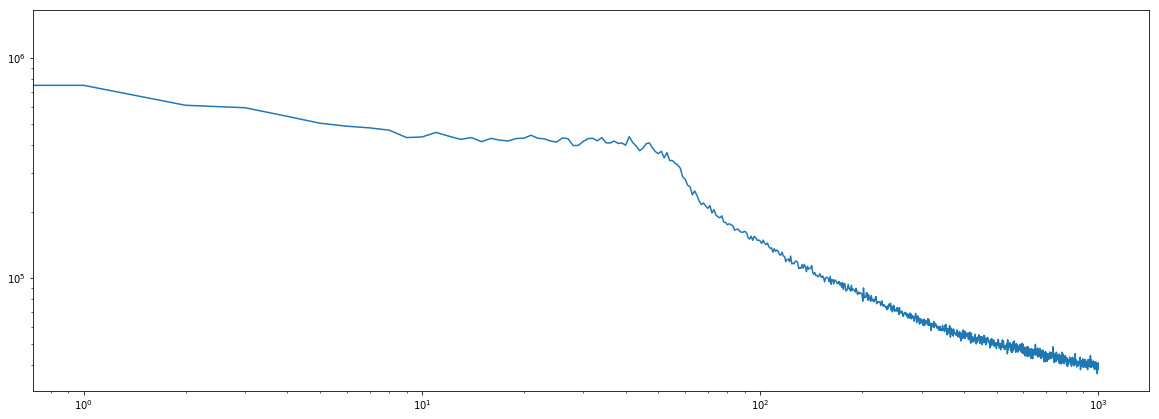

In [73]:
plt.plot(llist)
plt.loglog()

453


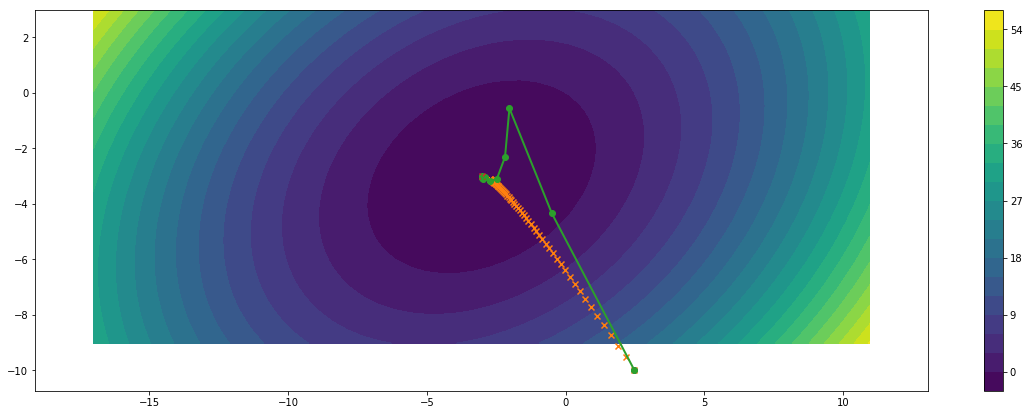

In [81]:
i_example = np.random.choice(X_test.shape[0])
print(i_example)

checklosses = []
checkstates = []

ind = np.array([i_example])
ix0, ixx, iyy, iAA = X0_test[ind], X_test[ind], Y_test[ind], A_test[ind]
# ix0, ixx, iyy, iAA = X0_train[ind], X_train[ind], Y_train[ind], A_train[ind]

il = 0 
checkstates.append(ix0)
_, l, ix = sess.run([opt_op, losst, xiter], 
                                  {xinp:ix0, xtrue:ixx, yy:iyy, AA:iAA,
                                   mygru._inputs:np.concatenate([ix0, ix0], axis=1)})

# checkstates = np.squeeze(np.array(checkstates))
checkstates = np.concatenate(ix)




plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar()
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1], c=colormap[4])
plt.scatter(X0_test[i_example][0], X0_test[i_example][1], marker='o')
# plt.scatter(X_min_train[i_example][0], X_min_train[i_example][1], c=colormap[4])
# plt.scatter(X0_train[i_example][0], X0_train[i_example][1])
plt.scatter(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], c=colormap[1], marker ='x')

plt.plot(checkstates[:,0], checkstates[:,1], c=colormap[2], lw=2)
plt.scatter(checkstates[:,0], checkstates[:,1], c=colormap[2], marker ='o')
plt.scatter(checkstates[:,0][-1], checkstates[:,1][-1], c=colormap[3], marker ='x')

# print(checkstates)